In [36]:
import random
from torch import tensor
import torch
import datetime

In [44]:
from config import get_weights_file_path, get_config

In [48]:
config = get_config()
get_weights_file_path(config, "7")

'EUR_USD_weights\\tmodel_7.pt'

In [47]:
config

{'security': 'EUR_USD',
 'provider': 'oanda',
 'train_batch_size': 128,
 'val_batch_size': 128,
 'num_epochs': 20,
 'lr': 0.001,
 'src_len': 256,
 'tgt_len': 32,
 'input_features': 10,
 'y_size': 10,
 'd_model': 64,
 'N': 6,
 'h': 8,
 'd_ff': 2048,
 'dropout': 0.1,
 'model_folder': 'weights',
 'model_basename': 'tmodel_',
 'preload': 'latest',
 'experiment_name': 'runs/tmodel',
 'datasource': 'EUR_USD',
 'max_train_size': 384,
 'max_val_size': 384}

In [37]:
def causal_mask(size):
    mask = torch.triu(torch.ones((1, size, size)), diagonal=0).type(torch.int)
    return mask == 0

mask = causal_mask(32)

In [40]:
causal_mask(32).shape

torch.Size([1, 32, 32])

In [33]:
from dataset import SequencesDataset
from torch.utils.data import Subset, DataLoader

In [26]:
pippo = SequencesDataset([[10], [12], [13]],[[0], [10], [10]], 1, 1)

In [27]:
lol = Subset(pippo, range(0, 3))

In [34]:
DataLoader(lol, batch_size=1, shuffle=True)

In [30]:
pippo[0]

{'encoder_input': tensor([10.]),
 'decoder_input': tensor([0.]),
 'decoder_mask': tensor([[[False]]]),
 'label': tensor([0.])}

In [208]:
import pyfinancialdata
from dataset import SequencesDataset

In [217]:
import pyfinancialdata
import pandas as pd
import numpy as np

def normalize_open_close(data: np.ndarray) -> tuple[np.ndarray, np.ndarray]:

    """Normalize with returns open and close prices. Returns two arrays: open and close returns.
    Opens are normalized based on the preceding close value."""

    opens = data[:, 3]
    closes = data[:, 0]
    assert opens.shape == closes.shape

    normalized_opens = np.zeros_like(opens)
    normalized_closes = (closes - opens) / opens * 100
    normalized_opens[1:] = (opens[1:] - opens[:-1]) / opens[:-1] * 100 # the first value is already zero
    
    return normalized_opens, normalized_closes


def normalize_highs_lows(data: np.ndarray) -> tuple[np.ndarray, np.ndarray]:

    """Normalize highs and lows as returns. Returns the two arrays: highs and lows."""

    opens = data[:, 3]
    highs = data[:, 1]
    lows = data[:, 2]
    assert opens.shape == highs.shape and highs.shape == lows.shape

    normalized_seq_highs = (highs - opens) / opens * 100
    normalized_seq_lows = (lows - opens) / opens * 100
    
    return normalized_seq_highs, normalized_seq_lows


def normalize_timestamp(data: np.ndarray) -> np.ndarray:

    """Normalize dates in a 0 to 1 range."""

    dates = data[:, -1]
    norm_dates = [[date.hour / 24, date.minute / 60, date.weekday() / 6, date.day / 31, date.month / 12] for date in dates]
    return np.asarray(norm_dates)

def generate_dataset(security: str, provider: str, src_len: int, tgt_len:int, first_year: int = 2000, last_year: int = 2024) -> tuple[np.ndarray, np.ndarray]:

    """Dataset generator. This is probably just pure crap that returns X, y"""

    seq_len = src_len + tgt_len
    data = [] # all years dataframes
    for year in range(first_year, last_year + 1):
        try:
            year_data = pyfinancialdata.get(provider, security, year)
            data.append(year_data)
        except KeyError:
            continue
    # columns = [time as index], close, high, low, open, volume
    data = pd.concat(data)
    data.drop("price", axis = 1, inplace=True) # price = close
    data["datetime"] = data.index # add the index as column
    data = data.to_numpy()
    # columns = close, high, low, open, volume, time
    # last_index = data.shape[0] // seq_len * seq_len
    # data = data[:last_index]
    # data_splits = np.array_split(data, data.shape[0] / seq_len)
    # data_splits = np.asarray(data_splits)
    data_splits = np.asarray(np.array_split(data[:data.shape[0] // seq_len * seq_len], data[:data.shape[0] // seq_len * seq_len].shape[0] / seq_len)) # splitting into sequences of seq len

    norm_dates = []
    for i in range(data_splits.shape[0]):
        # normalizing volumes
        data_splits[i, :, 4] = (data_splits[i, :, 4] - np.mean(data_splits[i, :, 4])) / np.std(data_splits[i, :, 4])
        # normalize prices time series
        data_splits[i, :, 1], data_splits[i, :, 2] = normalize_highs_lows(data_splits[i, :, :]) # highs and lows
        data_splits[i, :, 3], data_splits[i, :, 0] = normalize_open_close(data_splits[i, :, :]) # open and close 
        norm_dates.append(normalize_timestamp(data_splits[i, :, :])) # timestamp

    # seq dimensions = (close, high, low, open, volume, hour, minute, day_name_number, day, month) 
    data_splits = np.concatenate((data_splits[:, :, :-1], np.asarray(norm_dates)), axis = 2)

    X = data_splits[:, :src_len, :]
    y = data_splits[:, -tgt_len:, :]

    return X.astype("float32"), y.astype("float32")

In [218]:
X, y = generate_dataset("EUR_USD", "oanda", 256, 32)

c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\pyfinancialdata\get.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_data = price_data.append(pd.read_csv(csv_file, index_col=0))
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\pyfinancialdata\get.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_data = price_data.append(pd.read_csv(csv_file, index_col=0))
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\pyfinancialdata\get.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  price_data = price_data.append(pd.read_csv(csv_file, index_col=0))
c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\pyfinancialdata\get.p

In [219]:
X.shape

(19387, 256, 10)

In [220]:
data = SequencesDataset(X, y, 256, 32)

In [224]:
data

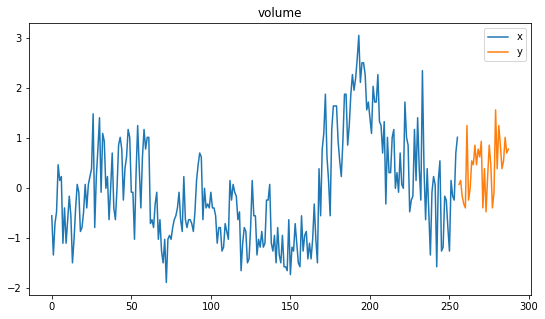

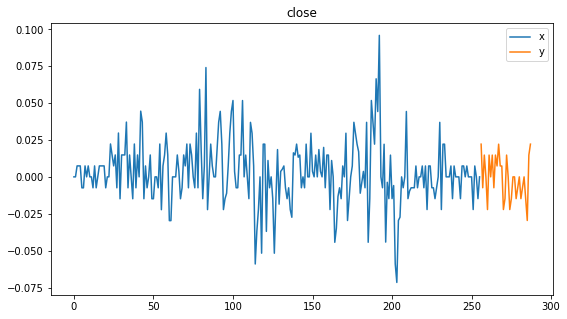

In [225]:
import matplotlib.pyplot as plt

n_seq = 2

src_len = X.shape[1]
tgt_len = y.shape[1]
plt.figure(figsize=(9, 5))
plt.plot(X[n_seq, :, 4], label = "x")
plt.plot([src_len + x for x in range(tgt_len)], y[n_seq, :, 4], label = "y")
plt.title("volume")
plt.legend()
plt.show()
plt.figure(figsize=(9, 5))
plt.plot(X[n_seq, :, 0], label = "x")
plt.plot([src_len + x for x in range(tgt_len)], y[n_seq, :, 0], label = "y")
plt.legend()
plt.title("close")
plt.show()